In [135]:
import pandas as pd
import numpy as np
import os,seaborn
from pandas import Series

from os.path import join, getsize

%matplotlib inline
import matplotlib.pyplot as plt

import sys

In [5]:
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Set seaborn aesthetic parameters to defaults
seaborn.set()


# 获取附件一中的所有文件路径
filepath = np.array([])
for root, dirs, files in os.walk('../data/attachment_1_100/'):
    filepath = np.concatenate((filepath,np.array([join(root, name) for name in files])))
print("\t".join(filepath[:3]))

../data/attachment_1_100/AA00001.csv	../data/attachment_1_100/AA00004.csv	../data/attachment_1_100/AA00052.csv
  vehicleplatenumber  device_num  direction_angle         lng        lat  \
0            AA00004  AAA9101004                0  115.923130  28.651311   
1            AA00004  AAA9101004                0  115.923106  28.651248   

   acc_state  right_turn_signals  left_turn_signals  hand_brake  foot_brake  \
0          1                   0                  0           0           0   
1          1                   0                  0           0           0   

         location_time  gps_speed  mileage  
0  2018-08-01 00:06:38          0     5559  
1  2018-08-01 00:06:39          0     5559  


In [ ]:
direction_angle_diff = []

### 速度差值、方位角角度分析

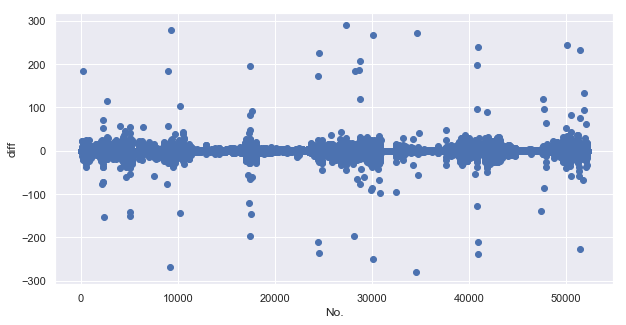

In [136]:
# for j in range(len(filepath)-70):

j=1
each_vehicle = pd.read_csv(filepath[j])

vehicle = each_vehicle
vehicle["index"] = vehicle.index
vehicle = vehicle.reset_index()


for i in range(len(vehicle)-1):

    # tmp = [speed_diff, direction, index]
    tmp = []
    tmp.append(vehicle.iloc[i+1]["gps_speed"]-vehicle.iloc[i]["gps_speed"])

    if vehicle.iloc[i]["direction_angle"] > 300 and vehicle.iloc[i+1]["direction_angle"] < 100:
        # 从左向右转，为负
        tmp.append(vehicle.iloc[i]["direction_angle"]-vehicle.iloc[i+1]["direction_angle"]-360)
    elif vehicle.iloc[i+1]["direction_angle"] > 300 and vehicle.iloc[i]["direction_angle"] < 100:
        # 从右向左转，为正
        tmp.append(vehicle.iloc[i]["direction_angle"]+360-vehicle.iloc[i+1]["direction_angle"])
    else:
        tmp.append(vehicle.iloc[i+1]["direction_angle"]-vehicle.iloc[i]["direction_angle"])

    tmp.append(vehicle.iloc[i]["index"])

    if tmp[0] !=0 and tmp[1]
    direction_angle_diff.append(tmp)

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Set seaborn aesthetic parameters to defaults
seaborn.set()
# plt.scatter(range(len(direction_angle_diff)),[item[0] for item in direction_angle_diff])
plt.scatter(range(len(direction_angle_diff)),[item[1] for item in direction_angle_diff])
plt.ylabel("diff")
plt.xlabel("No.")
plt.savefig("../image/direction_speed_diff/2" + filepath[j].split("/")[-1].split(".")[0] + ".jpg")
plt.show()

In [142]:
ddede = []
for i in direction_angle_diff:
    if i[0] != 0 and i[1]!=0:
        ddede.append(i)

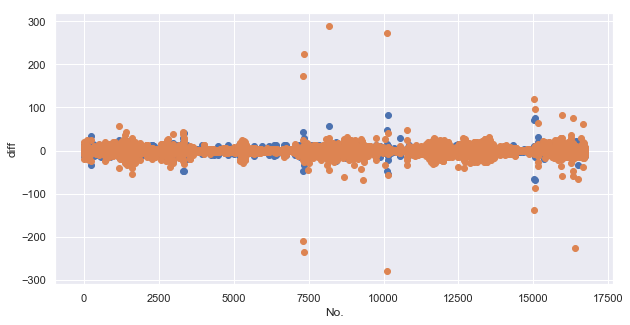

In [151]:
# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Set seaborn aesthetic parameters to defaults
seaborn.set()
plt.scatter(range(len(ddede)),[item[0] for item in ddede])
plt.scatter(range(len(ddede)),[item[1] for item in ddede])
plt.ylabel("diff")
plt.xlabel("No.")
# plt.savefig("../image/direction_speed_diff/2" + filepath[j].split("/")[-1].split(".")[0] + ".jpg")
plt.show()

### 卡尔曼滤波的实现

### 利用经纬度坐标来判断离群点

In [198]:
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371.393 # 地球平均半径，单位为公里
    return c * r * 1000

In [ ]:
for j in range(len(filepath)):

#     j=1
    vehicle = pd.read_csv(filepath[j])


    distance = [(i,haversine(vehicle.iloc[i+1]["lng"],vehicle.iloc[i+1]["lat"],
                                                 vehicle.iloc[i]["lng"],vehicle.iloc[i]["lat"])) for i in range(len(vehicle)-1)]

    # 每秒最大的距离
    max_distance_mil = max(list(set(vehicle["gps_speed"])))/3.6

    for i in distance:
        if i[1]>max_distance_mil:
            vehicle = vehicle.drop(index=i[0])


    vehicle.to_csv("data/" + filepath[j].split("/")[-1].split(".")[0] + ".csv")


    # Set the global default size of matplotlib figures
    plt.rc('figure', figsize=(10, 5))
    # Set seaborn aesthetic parameters to defaults
    seaborn.set()

    plt.scatter(range(len(distance)),[item[1] for item in distance])
    plt.ylabel("distance_before_process")
    plt.xlabel("item_index")
    plt.savefig("image/distance_image_before/" + filepath[j].split("/")[-1].split(".")[0] + "_before.jpg")
#     plt.show()
    plt.close()

In [202]:
# 每秒最大的距离
max_distance_mil = max(list(set(vehicle["gps_speed"])))/3.6


error_index =[i[0] for i in distance if i[1]>max_distance_mil]

vehicle = vehicle.drop(index=error_index)

KeyError: "['vehicleplatenumber' 'device_num' 'direction_angle' 'lng' 'lat'\n 'acc_state' 'right_turn_signals' 'left_turn_signals' 'hand_brake'\n 'foot_brake' 'location_time' 'gps_speed' 'mileage'] not found in axis"

#### 对重复项去重，并保留第一个出现的项

In [197]:
vehicle_tmp2 = vehicle.drop_duplicates(['lng','lat'],inplace=False)
vehicle_tmp2.to_csv("data/" + filepath[j].split("/")[-1].split(".")[0] + ".csv")

#### 绘制处理后距离的图形

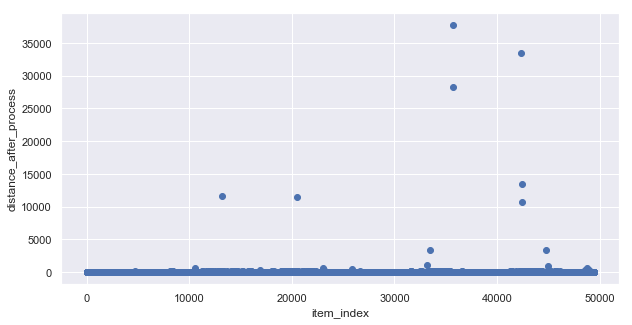

In [225]:
# vehicle = vehicle.reset_index()
distance_after = [(i,haversine(vehicle.iloc[i+1]["lng"],vehicle.iloc[i+1]["lat"],
                                             vehicle.iloc[i]["lng"],vehicle.iloc[i]["lat"])) for i in range(len(vehicle)-1)]

# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Set seaborn aesthetic parameters to defaults
seaborn.set()

plt.scatter(range(len(distance_after)),[item[1] for item in distance_after])
plt.ylabel("distance_after_process")
plt.xlabel("item_index")
plt.savefig("image/distance_image_after/" + filepath[j].split("/")[-1].split(".")[0] + "_after.jpg")
plt.show()
plt.close()